# cd huawei-working-folder

In [2]:
cd huawei-working-folder

C:\Users\dell\huawei-working-folder


In [23]:
import numpy as np
from pathlib import Path
import os
import cv2
import pickle
from pycocotools.coco import COCO
import patch as pat
import shutil

import matplotlib.pyplot as plt
import skimage.transform
import numpy as np
from PIL import Image

import torch.nn as nn
import keras.backend as K
from torch import tensor 

import warnings
warnings.filterwarnings("ignore", message="numpy.ndarray size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#https://blog.csdn.net/qq_38048756/article/details/103208834
domain = 'train/'

dataroot = 'FLIR_people_select/' 

jsonroot = 'FLIR_ADAS_1_3/' 
jsonfile = jsonroot + domain + 'thermal_annotations.json'
coco = COCO(jsonfile)

# path to store file
# path =

#domain = 'train/'


loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'FLIR_ADAS_1_3/train/thermal_annotations.json'

In [4]:
cd huawei-working-folder 

[WinError 2] 系统找不到指定的文件。: 'huawei-working-folder'
C:\Users\dell\huawei-working-folder


In [24]:
import pickle
with open ('FLIR_people_select_trainIdx', 'rb') as fp:
     idxs = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'FLIR_people_select_trainIdx'

In [26]:
idxs

[319,
 376,
 415,
 694,
 921,
 926,
 964,
 1499,
 1510,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1667,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 1676,
 1677,
 1678,
 1679,
 1680,
 1681,
 1682,
 1683,
 1684,
 1685,
 1686,
 1687,
 1688,
 1689,
 1691,
 1696,
 1697,
 1698,
 1703,
 1721,
 1722,
 1728,
 1730,
 1825,
 1831,
 1832,
 1848,
 1849,
 1857,
 1864,
 1867,
 1868,
 1896,
 1898,
 1899,
 1907,
 1914,
 1915,
 1916,
 1917,
 1920,
 1921,
 1922,
 1923,
 1924,
 1927,
 1940,
 1941,
 1942,
 1943,
 1958,
 1959,
 1981,
 1997,
 1998,
 1999,
 2002,
 2003,
 2004,
 2005,
 2010,
 2011,
 2019,
 2021,
 2059,
 2067,
 2073,
 2078,
 2079,
 2080,
 2081,
 2082,
 2088,
 2089,
 2090,
 2091,
 2092,
 2093,
 2094,
 2095,
 2096,
 2097,
 2098,
 2101,
 2102,
 2103,
 2108,
 2109,
 2129,
 2133,
 2134,
 2135,
 2136,
 2137,
 2138,
 2139,
 2140,
 2141,
 2187,
 2210,
 2211,
 2212,
 2213,
 2214,
 2215,
 2216,
 2242,
 2304,
 2307,
 2319,
 2354,
 2355,
 2395,
 2396,
 2398,
 2448,
 2449,
 2450,
 2485,
 2530,

In [27]:
import torch.nn as nn
import keras.backend as K
from torch import tensor 
import torch

In [7]:
### generate patches for a single image 
def valid_ann(ann):
    if ann['category_id'] == 1 and ann['bbox'][3]>120:
        return True
    else:
        return False

def generate_patch(idn,path_in_str,s,sig,angle,centers):
    imInfo = coco.imgs[idn]
    annIds = coco.getAnnIds(imgIds=imInfo['id']) #get annotations id of this image
    anns = coco.loadAnns(annIds)
    img = cv2.imread(path_in_str,0)
    for person_ann in anns:
        print(person_ann )
        if valid_ann(person_ann) == True:
            x,y,w,h = pat.patch_range(person_ann['bbox'],sig)
            print(x,y,w,h)
            #delete the rectangle when necessary
            cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
            box_size = (w,h)
            patch = pat.multiple_gussians(centers,s,sig ,box_size, x ,y)
            print(patch.shape)
            
            name = path_in_str[-15:-5]
            save_path = 'patched_image/train/'+ name
            
            #patche one
            im_p = pat.patched_image(img,patch,x,y,w,h)
            im = Image.fromarray(np.uint8(im_p))
            im.save(save_path + '.jpeg','JPEG')
            
            #rotated patch
            patch_rotate = pat.rand_rotate(patch,angle)
            im_p = pat.patched_image(img, patch_rotate,x,y,w,h)
            im = Image.fromarray(np.uint8(im_p))
            im.save(save_path + '_r.jpeg','JPEG')
            
            #bright-changed patch
            patch_bright = pat.adjust_contrast_bri(contrast,brightness,patch)
            im_p = pat.patched_image(img, patch_bright ,x,y,w,h)
            im = Image.fromarray(np.uint8(im_p))
            im.save(save_path + '_b.jpeg','JPEG')
        else:
            continue

        
#generate patches for image in a domain
def generate_patches(centers,domain,s,sig,rotate_ran):
    if domain == 'train/':
        with open ('FLIR_people_select_trainIdx', 'rb') as fp:
            idxs = pickle.load(fp)
    elif domain =='val/':
        with open ('FLIR_people_select_valIdx', 'rb') as fp:
            idxs = pickle.load(fp)
    #patch_sum = patch.multiple_gussians(centers)
    path = dataroot + domain 
    pathlist = Path(path).rglob('*.jpeg')
    for path,idn in zip(pathlist,idxs):
        path_in_str = str(path)
        print(path_in_str)
        generate_patch(idn,path_in_str,s,sig,rotate_ran,centers)
        #save image in FLIR/patched_image/train
    
    #file path of the patched images  
    return 

#directly modify image, not store it
def model_patches(img,ind,centers,s,sig,rotate_ran):
    import tensorflow as tf
    from tensorflow.python.framework.ops import enable_eager_execution
    enable_eager_execution()
    imInfo = coco.imgs[ind]
    annIds = coco.getAnnIds(imgIds=imInfo['id']) #get annotations id of this image
    anns = coco.loadAnns(annIds)
    #img = cv2.imread(path_in_str,0)
    for person_ann in anns:
        if valid_ann(person_ann) == True:
            x,y,w,h = pat.patch_range(person_ann['bbox'],sig)
            #print(x,y,w,h)
            #delete the rectangle when necessary
            #cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
            box_size = (w,h)
            patch = pat.multiple_gussians(centers,s,sig ,box_size, x ,y)
            #print(patch.shape)
            
            #patche one
            im_p = pat.patched_image(img,patch,x,y,w,h)
            im = tf.convert_to_tensor(value, dtype=None, dtype_hint=None, name=None)
            #im = Image.fromarray(np.uint8(im_p))
            #im.save(save_path + '.jpeg','JPEG')
            
            #rotated patch
            patch_rotate = pat.rand_rotate(patch,angle)
            im_r = pat.patched_image(img, patch_rotate,x,y,w,h)
            #im = Image.fromarray(np.uint8(im_p))
            #im.save(save_path + '_r.jpeg','JPEG')
            
            #bright-changed patch
            patch_bright = pat.adjust_contrast_bri(contrast,brightness,patch)
            im_b = pat.patched_image(img, patch_bright ,x,y,w,h)
            #im = Image.fromarray(np.uint8(im_p))
            #im.save(save_path + '_b.jpeg','JPEG')
            
            return im,im_r,im_b
        else:
            continue
    
    
def yolo_scores(path):
    pathlist = Path(path).rglob('*.txt')
    scores_yolo = list()
    images = list()
    count = 0
    for path in pathlist:
        count += 1
        image = list()
        f = open(path,'r')
        lines = f.readlines()
        for line in lines:
            num_list = line.split()
            #print(num_list)
            if num_list[0] == "0":
                image.append(float(num_list[-1]))  
        if count == 4:
            scores_yolo.append(images)
            images = list()
            count = 0
        else:
            images.append(image)
    return scores_yolo
                
def yolov3_(centers):
    patch_images = generate_patches(centers) #path to folders store the images
    ...
    #use terminal command instead of function
    return scores # a list
def faster_rcnn_scores():
    generate_patches(centers)
    ...
    return scores # alist
def loss_function(centers):
    detector1_scores = yolov3_scores(centers)
    #detector2_scores = faster_rcnn_scores(centers)
    #L1_detector =  


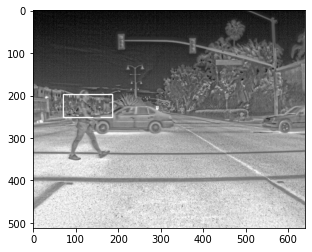

In [8]:
imgname = 'FLIR_00320.jpeg'
img = cv2.imread(imgname)
plt.imshow(img)

In [9]:
#import tensorflow as tf
#image_raw = tf.io.read_file(imgname)
#image = tf.image.decode_image(image_raw,dtype=tf.dtypes.float32)

### Install pytorch-yolov3 api/get inference score



#image

def yolov3_score(img):
    import cv2
    from pytorchyolo import detect, models
    
    #img = cv2.imread('FLIR_08486.jpeg')
    #img convert type
    # Load the YOLO model
    model = models.load_model(
      "config/yolov3.cfg", 
      "weights/yolov3.weights")

    # Load the image as a numpy array

    # Convert OpenCV bgr to rgb
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Runs the YOLO model on the image 
    boxes = detect.detect_image(model, img)
    for each in boxes:
        if each[-1] == 0:
            score = each[-2]
    print(score)
# Output will be a numpy array in the following format:
# [[x1, y1, x2, y2, confidence, class]]

def input_preprocess():
    im_nd = image.numpy()
    im_nd = np.repeat(im_nd, 3, axis=2)
    yolov3_score(im_nd)

### Yolov3

In [10]:
pwd

'C:\\Users\\dell\\huawei-working-folder'

In [4]:
cd huawei-working-folder\yolov3


[WinError 3] 系统找不到指定的路径。: 'huawei-working-folder\\yolov3'
C:\Users\dell\huawei-working-folder


In [12]:
cd yolov3

C:\Users\dell\huawei-working-folder\yolov3


In [13]:
from yolov3.utils import loss
from models import yolo
import models
from models.experimental import attempt_load
# Load model
#model = attempt_load(weights='weights/yolov3.pt')

In [14]:
import yaml
with open('data/hyp.finetune.yaml') as f:
    hyp = yaml.safe_load(f)

In [15]:
model = yolo.Model('models/yolov3.yaml', ch=3, nc=80,anchors=hyp.get('anchors')).to('cpu')

In [16]:
from utils.loss import ComputeLoss
model.hyp = hyp
model.gr = 1
compute_loss = ComputeLoss(model)

In [17]:
from torch import tensor 
from utils.general import labels_to_class_weights, increment_path, labels_to_image_weights, init_seeds, \
    fitness, strip_optimizer, get_latest_run, check_dataset, check_file, check_git_status, check_img_size, \
    check_requirements, print_mutation, set_logging, one_cycle, colorstr

In [18]:
pwd

'C:\\Users\\dell\\huawei-working-folder\\yolov3'

In [42]:
class opt2():
    def __init__(self):
        self.cache_images =1
        self.rect = 0
        self.world_size =1
        self.quad=1
        self.workers = 0
        self.image_weights = 0
        self.single_cls = 0

In [43]:
opt=opt2()

In [48]:
from utils.datasets import create_dataloader
import torch.optim as optim

train_path = 'patched_image'
imgsz = 512
batch_size = 1
gs = 1


dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                        hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect, rank=-1,
                                        world_size=opt.world_size, workers=opt.workers,
                                        image_weights=opt.image_weights, quad=opt.quad, prefix=colorstr('train: '))
pbar = enumerate(dataloader)

train: Scanning 'patched_image\train\labels.cache' images and labels... 2130 found, 0 missing, 0 empty, 3 corrupted: 10
train: Caching images (1.3GB): 100%|██████████████████████████████████████████████| 2127/2127 [00:08<00:00, 264.26it/s]


#### Update weights and biases

In [58]:
#optimizer
import torch.nn as nn

pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
for k, v in model.named_modules():
    if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):
        pg2.append(v.bias)  # biases
    if isinstance(v, nn.BatchNorm2d):
        pg0.append(v.weight)  # no decay
    elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):
        pg1.append(v.weight)  # apply decay
optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
logger.info('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))

In [16]:
for k, v in model.named_modules():
    print('k',k)
    print('v',v)

k 
v Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, moment

k model.19.cv1.bn
v BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
k model.19.cv1.act
v LeakyReLU(negative_slope=0.1, inplace=True)
k model.19.cv2
v Conv(
  (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(512, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.1, inplace=True)
)
k model.19.cv2.conv
v Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
k model.19.cv2.bn
v BatchNorm2d(512, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
k model.19.cv2.act
v LeakyReLU(negative_slope=0.1, inplace=True)
k model.20
v Bottleneck(
  (cv1): Conv(
    (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(256, 

In [21]:
import torch.nn as nn

for k, v in model.named_modules():
    if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):
        print(v.bias.shape)  # biases
    if isinstance(v, nn.BatchNorm2d):
        print(v.weight.shape)  # no decay
    elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):
        print(v.weight.shape)  # apply decay

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([32, 64, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([64, 128, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([64, 128, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torc

In [5]:
# Download COCO128
import torch
from IPython.display import Image, clear_output  # to display images

#clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
#torch.hub.download_url_to_file('https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip', 'tmp.zip')


Setup complete. Using torch 1.7.1+cu110 (CPU)


In [62]:
#normal
from torch.cuda import amp
import torch
import torch.optim as optim


optimizer.zero_grad()
for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
    #print('!!!!!!!!!!!!!!!!!!!!!pbar:',pbar)
    #rint('!!!!!!!!!!!!!!!!!!!!!imgs:',imgs)
    #print('!!!!!!!!!!!!!!!!!!!!!targets:',targets)
    #print('!!!!!!!!!!!!!!!!!!!!!paths:',paths)
    #print('!!!!!!!!!!!!!!!!!!!!!_:',_)
    #import torchvision
    #images = torchvision.transforms.functional.to_tensor(imgs)
    imgs = imgs.to(torch.float)
    print('image shape:',imgs.shape)
    pred = model(imgs)  # forward
    ##print('pred:',pred)
    loss, loss_items = compute_loss(pred, targets.to('cpu'))
    if opt.quad:
        loss *= 4.
    print('loss:',loss)
    print('obj_loss:',loss_items[1])
    scaler = amp.GradScaler()
    scaler.scale(loss).backward()
    #if ni % accumulate == 0:
    scaler.step(optimizer)  # optimizer.step
    scaler.update()
    optimizer.zero_grad()

image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.61166e-01,  1.88685e-01, -5.74736e-02,  ..., -4.97442e+00, -5.22808e+00, -4.87516e+00],
           [-2.91510e-01,  2.41377e-01, -7.69468e-02,  ..., -4.93334e+00, -4.83999e+00, -4.72866e+00],
           [-2.09561e-01,  9.21651e-02,  3.07074e-01,  ..., -4.85980e+00, -4.78662e+00, -4.43040e+00],
           ...,
           [-1.89241e-01,  1.29724e-01, -2.13887e-01,  ..., -4.35693e+00, -4.95129e+00, -4.83926e+00],
           [ 1.47252e-01,  4.04662e-01, -2.43645e-01,  ..., -4.49160e+00, -4.75127e+00, -4.78994e+00],
           [-6.27915e-02,  5.37473e-02, -5.55496e-02,  ..., -4.53874e+00, -5.26942e+00, -4.55178e+00]],

          [[-3.54206e-01,  2.10531e-01,  1.37583e-01,  ..., -4.95569e+00, -4.77245e+00, -4.77245e+00],
           [ 4.35125e-03,  3.74326e-01, -4.64394e-02,  ..., -4.94068e+00, -4.93412e+00, -4.32320e+00],
           [-4.71967e-01,  3.21419e-01,  1.05581e-01,  ..., -4.99715e+00, -4.98869e+00, -4.61394e+00],
    

loss: tensor([3.51991], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01122)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.68897e-01,  2.84516e-01, -1.41977e-01,  ..., -4.99591e+00, -4.96651e+00, -4.63655e+00],
           [-3.72878e-01,  2.17427e-01,  1.82967e-01,  ..., -5.02332e+00, -4.87377e+00, -4.55427e+00],
           [-3.47884e-01,  2.48095e-01, -6.41164e-02,  ..., -5.01179e+00, -5.01066e+00, -4.52718e+00],
           ...,
           [-4.35576e-01, -3.16806e-02, -4.55800e-01,  ..., -4.52111e+00, -5.02855e+00, -4.15198e+00],
           [-3.18377e-01,  1.32289e-01, -3.37414e-01,  ..., -4.63797e+00, -4.81470e+00, -4.54205e+00],
           [ 3.79333e-02,  3.44452e-01, -2.25538e-01,  ..., -4.76876e+00, -5.06286e+00, -4.48225e+00]],

          [[-4.52398e-01,  1.72344e-01,  3.14459e-02,  ..., -5.20351e+00, -4.80640e+00, -4.99577e+00],
           [-6.33891e-01,  4.03726e-01, -5.83793e-02,  ..., -4.93047e+00, -5.16582e+00, -4.87752e+00],
           [-4.56226e-01,  5.7522

loss: tensor([3.43617], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01178)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.15602e-01,  2.69607e-01, -6.90405e-02,  ..., -4.83520e+00, -5.06023e+00, -4.79533e+00],
           [-1.85467e-01,  3.14969e-01,  3.25179e-01,  ..., -4.86581e+00, -5.23374e+00, -4.48770e+00],
           [-9.33897e-02, -7.76544e-02,  1.03981e-02,  ..., -4.99738e+00, -4.80505e+00, -4.29564e+00],
           ...,
           [-3.40973e-01, -4.96892e-02, -4.79180e-01,  ..., -4.26761e+00, -4.92865e+00, -4.62450e+00],
           [-1.19684e-01, -4.41823e-01, -2.78036e-01,  ..., -4.63204e+00, -4.62289e+00, -5.05443e+00],
           [-1.89574e-01, -7.47706e-02, -1.70367e-01,  ..., -4.62049e+00, -5.11179e+00, -4.89503e+00]],

          [[-2.73130e-01, -1.69674e-02,  1.11586e-01,  ..., -4.86236e+00, -4.96816e+00, -4.74019e+00],
           [-1.07149e-01,  3.30109e-01,  2.69399e-01,  ..., -4.82064e+00, -5.19181e+00, -4.04015e+00],
           [-3.64834e-01, -5.1137

loss: tensor([3.62709], grad_fn=<MulBackward0>)
obj_loss: tensor(0.00960)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.40721e-01,  2.94603e-01, -6.24066e-02,  ..., -4.92420e+00, -4.91116e+00, -4.70740e+00],
           [-3.58606e-01,  1.83780e-01,  1.01938e-01,  ..., -5.08064e+00, -4.67428e+00, -4.40339e+00],
           [-2.34107e-01,  1.54143e-01, -2.80103e-01,  ..., -5.06400e+00, -4.81170e+00, -4.52557e+00],
           ...,
           [-1.02626e-01,  2.66016e-01, -9.92762e-02,  ..., -4.82124e+00, -4.88368e+00, -4.57287e+00],
           [-9.32138e-02,  1.27450e-01, -8.88489e-02,  ..., -4.63443e+00, -4.81979e+00, -4.40837e+00],
           [ 5.01381e-02,  8.39907e-03, -1.23585e-02,  ..., -4.80667e+00, -5.13483e+00, -4.70526e+00]],

          [[-3.52434e-01,  2.62296e-01, -1.05649e-01,  ..., -4.89167e+00, -4.84945e+00, -4.91654e+00],
           [-4.84352e-01,  3.72242e-01, -9.64192e-02,  ..., -4.80659e+00, -4.96068e+00, -4.62931e+00],
           [-5.74185e-01,  3.1085

loss: tensor([3.42402], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01000)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-4.65779e-01,  3.95441e-01, -5.38783e-01,  ..., -4.95529e+00, -5.25733e+00, -5.09621e+00],
           [-7.43057e-01,  5.00458e-01, -3.51873e-01,  ..., -4.80579e+00, -5.23729e+00, -5.21843e+00],
           [-2.84199e-01,  3.39375e-01,  1.93735e-01,  ..., -4.73773e+00, -4.69447e+00, -4.22016e+00],
           ...,
           [-1.15474e-01,  4.01420e-01,  1.35631e-01,  ..., -5.02426e+00, -5.06792e+00, -4.42040e+00],
           [-1.10154e-01,  3.83606e-01,  7.39955e-02,  ..., -4.90519e+00, -5.13163e+00, -4.42879e+00],
           [-4.45473e-02,  5.27710e-02,  1.75753e-01,  ..., -4.87615e+00, -5.08037e+00, -4.58259e+00]],

          [[-5.07340e-01,  4.74268e-01, -6.40637e-01,  ..., -4.95494e+00, -4.88378e+00, -5.15838e+00],
           [-1.22080e+00,  4.60535e-01, -1.18188e+00,  ..., -4.20817e+00, -4.52292e+00, -4.79084e+00],
           [-2.99992e-01,  3.8070

loss: tensor([3.50630], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01339)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-7.67838e-02,  4.26682e-02,  3.45669e-02,  ..., -4.89228e+00, -4.85953e+00, -4.57943e+00],
           [-2.33764e-01,  1.90468e-01,  3.91129e-01,  ..., -4.97327e+00, -4.97100e+00, -4.89727e+00],
           [-3.03294e-01,  4.86640e-02,  9.70029e-03,  ..., -4.94956e+00, -4.80479e+00, -4.53015e+00],
           ...,
           [-6.61698e-02,  2.88538e-01, -3.00213e-01,  ..., -4.69980e+00, -4.84328e+00, -4.34818e+00],
           [-3.41732e-02,  3.73482e-01, -1.23645e-01,  ..., -4.73514e+00, -4.46648e+00, -4.53464e+00],
           [ 6.87807e-02,  1.59105e-01,  1.98340e-02,  ..., -4.44372e+00, -5.02627e+00, -4.52232e+00]],

          [[-2.69226e-01,  1.00422e-01,  4.07362e-01,  ..., -5.03270e+00, -4.87284e+00, -4.81090e+00],
           [-3.00357e-01,  5.17494e-01,  2.29451e-01,  ..., -4.68863e+00, -5.03866e+00, -4.75554e+00],
           [-5.27603e-01, -1.5776

loss: tensor([3.44610], grad_fn=<MulBackward0>)
obj_loss: tensor(0.00825)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.10442e-01,  1.28609e-01, -3.20233e-02,  ..., -4.83800e+00, -5.01225e+00, -4.82157e+00],
           [-5.59534e-01,  1.06719e-01,  4.39506e-02,  ..., -4.66508e+00, -5.14463e+00, -4.66185e+00],
           [-3.57419e-02,  2.75170e-01, -2.54967e-03,  ..., -4.75159e+00, -4.92453e+00, -4.86922e+00],
           ...,
           [-1.19046e-01, -1.81601e-01, -1.76841e-01,  ..., -4.30786e+00, -4.94847e+00, -4.66364e+00],
           [-4.01430e-03, -2.04754e-02, -1.60901e-01,  ..., -4.80813e+00, -4.53409e+00, -4.70398e+00],
           [-1.96674e-01, -8.91701e-02, -4.41080e-02,  ..., -4.53442e+00, -5.14592e+00, -4.71315e+00]],

          [[-5.50794e-01,  4.14228e-01,  1.49999e-01,  ..., -4.84705e+00, -5.11455e+00, -4.94277e+00],
           [-2.00202e-01,  3.21752e-01, -2.05021e-02,  ..., -4.75372e+00, -5.04340e+00, -4.77736e+00],
           [-4.90207e-01, -2.1695

loss: tensor([3.54647], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01121)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.08260e-01,  4.58771e-02,  1.39659e-01,  ..., -5.08935e+00, -4.86311e+00, -4.81195e+00],
           [-2.26330e-01,  3.11124e-01,  3.17574e-01,  ..., -4.87245e+00, -5.03768e+00, -4.68517e+00],
           [-3.97982e-01,  4.68931e-02,  9.92167e-03,  ..., -4.90766e+00, -5.02277e+00, -4.61664e+00],
           ...,
           [-2.24109e-01, -1.55742e-01, -4.01688e-01,  ..., -4.80237e+00, -5.07885e+00, -4.43358e+00],
           [-1.93010e-01,  2.00650e-02, -1.04831e-01,  ..., -4.90427e+00, -4.51714e+00, -4.60599e+00],
           [-1.23889e-01,  7.13183e-02, -9.62325e-02,  ..., -4.68905e+00, -5.32682e+00, -4.58382e+00]],

          [[-3.68873e-01,  4.88783e-02,  4.34251e-02,  ..., -4.98912e+00, -4.95542e+00, -4.65241e+00],
           [-3.18830e-01,  5.77770e-01,  3.09836e-01,  ..., -5.15387e+00, -5.37359e+00, -4.57940e+00],
           [-5.99595e-01,  2.6769

loss: tensor([3.57741], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01011)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-4.01994e-01,  4.03372e-02, -2.69463e-01,  ..., -4.69647e+00, -4.94994e+00, -5.01190e+00],
           [-4.92913e-01,  1.62777e-01, -3.34898e-01,  ..., -4.72507e+00, -4.88614e+00, -4.94681e+00],
           [-2.24251e-01,  5.53173e-01, -1.56942e-01,  ..., -4.63268e+00, -5.18353e+00, -4.70228e+00],
           ...,
           [ 6.10118e-03,  1.84800e-01, -1.89623e-01,  ..., -4.76598e+00, -5.02149e+00, -4.51092e+00],
           [ 1.15994e-01,  9.53365e-02, -1.73149e-01,  ..., -4.74878e+00, -5.06375e+00, -4.64880e+00],
           [-1.48960e-01,  3.29947e-02, -6.85252e-02,  ..., -4.58697e+00, -5.09185e+00, -4.57002e+00]],

          [[-4.81219e-01,  3.85138e-01,  1.82361e-01,  ..., -5.05030e+00, -4.55080e+00, -4.80360e+00],
           [-3.88040e-01,  6.56198e-01, -1.75714e-01,  ..., -4.78597e+00, -5.08065e+00, -4.62837e+00],
           [-5.65908e-01,  1.3667

loss: tensor([3.54391], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01189)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[ 7.72270e-02,  2.71927e-01, -9.17047e-02,  ..., -4.89885e+00, -4.86277e+00, -4.73259e+00],
           [-3.60709e-01,  2.37065e-01,  2.01527e-01,  ..., -5.09322e+00, -4.79642e+00, -4.64043e+00],
           [-3.11274e-02,  2.69482e-01, -7.89477e-02,  ..., -5.09615e+00, -4.95203e+00, -4.56948e+00],
           ...,
           [-1.49329e-01, -1.75277e-02, -2.96178e-01,  ..., -4.52689e+00, -4.91099e+00, -4.45576e+00],
           [-3.08554e-01, -4.20341e-02, -1.36372e-01,  ..., -4.77185e+00, -4.74581e+00, -4.76033e+00],
           [ 1.22240e-01,  7.69148e-02, -2.08108e-01,  ..., -4.68725e+00, -5.12058e+00, -4.20472e+00]],

          [[-3.04097e-01,  3.81926e-01, -2.84176e-02,  ..., -5.04676e+00, -4.80609e+00, -5.01340e+00],
           [-2.84136e-01,  3.61307e-01, -1.93265e-01,  ..., -4.97982e+00, -4.86247e+00, -4.67589e+00],
           [-4.82689e-01,  4.8662

loss: tensor([3.56706], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01133)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.61775e-01,  1.79323e-01, -8.90609e-02,  ..., -5.04761e+00, -4.90594e+00, -4.77097e+00],
           [-3.56891e-01,  3.09163e-01,  1.11733e-01,  ..., -4.98577e+00, -4.53464e+00, -4.30336e+00],
           [-1.36514e-01,  2.27729e-01, -1.30286e-01,  ..., -4.90390e+00, -4.95089e+00, -4.63098e+00],
           ...,
           [-4.50508e-02, -1.52199e-01, -1.96804e-01,  ..., -4.41428e+00, -4.90458e+00, -4.53265e+00],
           [-3.03431e-02,  8.99924e-02, -9.73129e-02,  ..., -4.67624e+00, -4.59553e+00, -4.65276e+00],
           [-1.55938e-01, -8.32814e-02, -2.38812e-02,  ..., -4.60063e+00, -4.96860e+00, -4.76708e+00]],

          [[-2.92335e-01,  3.04993e-01, -5.53697e-02,  ..., -4.63371e+00, -4.90817e+00, -4.96461e+00],
           [-2.02801e-01,  5.00111e-01, -1.59734e-01,  ..., -4.72089e+00, -4.92443e+00, -4.29940e+00],
           [-3.23533e-01,  5.1544

loss: tensor([3.52958], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01327)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.21609e-01, -6.22451e-04, -4.81871e-01,  ..., -5.14924e+00, -4.81922e+00, -4.73412e+00],
           [-5.24520e-01,  6.51050e-01, -2.17161e-01,  ..., -4.62791e+00, -5.10398e+00, -4.03301e+00],
           [-2.18030e-01,  4.96311e-01,  1.55794e-01,  ..., -4.29444e+00, -4.81470e+00, -3.81776e+00],
           ...,
           [-2.22464e-01,  1.13155e-03, -4.04242e-01,  ..., -4.56405e+00, -4.58952e+00, -4.32411e+00],
           [-2.39451e-01, -1.06465e-01, -3.36548e-01,  ..., -4.56751e+00, -4.81677e+00, -4.82458e+00],
           [-1.76839e-01, -3.27816e-02,  9.95545e-02,  ..., -4.47957e+00, -5.03078e+00, -4.62321e+00]],

          [[-4.80173e-01, -1.21066e-01, -1.35180e+00,  ..., -5.59266e+00, -4.55434e+00, -4.58032e+00],
           [-2.39670e-01,  6.94548e-01, -5.20697e-01,  ..., -4.29066e+00, -4.56434e+00, -3.52540e+00],
           [-3.14344e-01, -2.4182

loss: tensor([3.58018], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01034)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.96589e-01,  1.60369e-01,  1.88737e-01,  ..., -4.98041e+00, -4.86053e+00, -4.76191e+00],
           [-4.15636e-01,  2.85336e-01,  4.72864e-01,  ..., -4.96586e+00, -5.08945e+00, -4.66686e+00],
           [-3.35168e-01,  8.24371e-02,  3.88146e-02,  ..., -5.19517e+00, -5.07674e+00, -4.66123e+00],
           ...,
           [-9.65359e-02,  1.27529e-01, -3.37487e-01,  ..., -4.45816e+00, -4.93784e+00, -4.48498e+00],
           [ 6.52818e-02, -4.15244e-02, -2.53182e-01,  ..., -4.43180e+00, -4.64021e+00, -4.80790e+00],
           [-1.48000e-01, -4.31591e-02, -9.92752e-02,  ..., -4.55310e+00, -5.03404e+00, -4.48677e+00]],

          [[-2.58207e-01,  4.99401e-02,  7.09513e-02,  ..., -4.95764e+00, -4.92522e+00, -4.75692e+00],
           [-3.33280e-01,  4.41029e-03,  3.27799e-01,  ..., -4.77739e+00, -5.25820e+00, -4.41200e+00],
           [-4.92854e-01, -2.5935

loss: tensor([3.43663], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01087)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.33240e-01,  1.54140e-01, -1.08939e-01,  ..., -4.85045e+00, -4.93863e+00, -4.54584e+00],
           [-2.04251e-01,  5.63540e-02, -7.95154e-02,  ..., -4.91487e+00, -4.92366e+00, -4.20630e+00],
           [-1.25420e-01,  3.00631e-01, -1.42409e-02,  ..., -5.14751e+00, -4.77881e+00, -4.65722e+00],
           ...,
           [-3.19333e-01,  1.75570e-01,  9.27530e-02,  ..., -4.86814e+00, -4.99071e+00, -4.69339e+00],
           [-2.55585e-01,  3.65070e-01, -2.58800e-01,  ..., -4.89152e+00, -4.83370e+00, -4.69305e+00],
           [-2.22265e-01,  1.71373e-01, -5.35175e-05,  ..., -4.88701e+00, -5.06888e+00, -4.52467e+00]],

          [[-2.65386e-01,  2.34215e-01,  9.19580e-04,  ..., -4.55094e+00, -4.79093e+00, -4.83777e+00],
           [-3.64512e-01,  4.23687e-01, -5.13524e-02,  ..., -4.66193e+00, -5.02981e+00, -4.45043e+00],
           [-5.95134e-01,  1.9183

loss: tensor([3.39019], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01042)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.61382e-01,  1.12497e-01, -5.85632e-02,  ..., -5.04825e+00, -5.12874e+00, -4.90360e+00],
           [-2.18749e-01,  1.22592e-01,  2.92896e-01,  ..., -4.75042e+00, -4.93707e+00, -4.80407e+00],
           [-3.92717e-02,  9.28572e-02,  4.67026e-02,  ..., -4.90668e+00, -5.05971e+00, -4.55405e+00],
           ...,
           [-2.47565e-01, -1.14232e-01, -2.68187e-01,  ..., -4.42967e+00, -5.04001e+00, -4.51985e+00],
           [-2.95378e-02, -6.30066e-02, -2.44036e-01,  ..., -4.70337e+00, -4.70407e+00, -4.71587e+00],
           [-9.73861e-02, -9.62870e-02, -2.60689e-02,  ..., -4.50719e+00, -4.98492e+00, -4.69760e+00]],

          [[-2.00022e-01,  2.02212e-01,  5.33440e-02,  ..., -4.94173e+00, -5.18635e+00, -4.95915e+00],
           [-4.13771e-01,  2.44106e-01, -5.02079e-02,  ..., -4.69017e+00, -5.51715e+00, -4.67503e+00],
           [-2.56755e-01,  6.5296

loss: tensor([3.52016], grad_fn=<MulBackward0>)
obj_loss: tensor(0.00973)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.35367e-01,  2.44652e-01,  1.16111e-01,  ..., -4.99109e+00, -4.86771e+00, -4.71480e+00],
           [-2.03337e-01,  3.11964e-01,  2.33368e-01,  ..., -4.87197e+00, -5.12903e+00, -4.71252e+00],
           [-1.92043e-01,  2.76924e-01,  7.00411e-02,  ..., -4.97340e+00, -5.07065e+00, -4.63591e+00],
           ...,
           [-1.03034e-02,  2.12475e-01, -3.62872e-01,  ..., -4.32400e+00, -4.79432e+00, -4.68341e+00],
           [ 1.33182e-01,  1.00307e-01, -9.59046e-02,  ..., -4.60402e+00, -4.64808e+00, -4.81219e+00],
           [-1.10295e-01,  9.45258e-03, -6.12060e-03,  ..., -4.54268e+00, -5.03897e+00, -4.64240e+00]],

          [[-2.75873e-01, -1.42751e-02,  2.61081e-01,  ..., -4.85468e+00, -5.00591e+00, -4.96032e+00],
           [-3.37774e-01,  2.59011e-01,  4.86821e-01,  ..., -4.85454e+00, -5.22470e+00, -4.62166e+00],
           [-5.18546e-01,  1.4275

loss: tensor([3.55922], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01263)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.50337e-01,  2.47051e-01, -3.71538e-02,  ..., -5.05057e+00, -4.77187e+00, -4.73960e+00],
           [-4.89646e-01,  6.42179e-01,  1.80980e-01,  ..., -4.99171e+00, -4.90298e+00, -4.73550e+00],
           [-2.92079e-01,  1.26832e-01,  7.17892e-02,  ..., -5.13493e+00, -4.94764e+00, -4.65485e+00],
           ...,
           [-1.19606e-01,  3.19328e-01,  2.17928e-01,  ..., -4.88496e+00, -4.92592e+00, -4.30592e+00],
           [ 1.40069e-01,  7.03481e-02, -2.43284e-01,  ..., -4.88557e+00, -4.87886e+00, -4.69489e+00],
           [ 6.73308e-02,  2.13633e-01,  2.11013e-02,  ..., -4.61667e+00, -5.24482e+00, -4.58540e+00]],

          [[-5.70374e-02,  9.89835e-03, -6.29055e-02,  ..., -4.85413e+00, -4.95628e+00, -4.97560e+00],
           [-3.30432e-01,  5.81807e-01, -1.67696e-01,  ..., -4.75765e+00, -5.37409e+00, -4.52728e+00],
           [-5.00577e-01, -1.5735

loss: tensor([3.51622], grad_fn=<MulBackward0>)
obj_loss: tensor(0.00896)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-1.57916e-01,  9.60940e-02, -7.26119e-02,  ..., -4.85582e+00, -4.90071e+00, -4.74971e+00],
           [-4.31350e-01,  3.10534e-01,  8.44685e-02,  ..., -4.84483e+00, -4.87934e+00, -4.30819e+00],
           [-2.00186e-01,  3.79509e-01,  4.99636e-02,  ..., -5.05553e+00, -4.91436e+00, -4.84170e+00],
           ...,
           [-2.22075e-01,  2.39404e-01,  1.05791e-02,  ..., -5.00356e+00, -5.04789e+00, -4.47244e+00],
           [-1.64496e-01,  2.44328e-01, -6.58439e-02,  ..., -5.00339e+00, -4.96483e+00, -4.60710e+00],
           [-8.14194e-02,  5.78342e-02,  5.36157e-02,  ..., -4.69818e+00, -5.19874e+00, -4.56477e+00]],

          [[-3.17641e-01,  1.72424e-01, -1.74433e-03,  ..., -4.68330e+00, -4.60169e+00, -5.08587e+00],
           [-3.94538e-01,  6.35787e-01, -2.34068e-01,  ..., -4.81610e+00, -4.88272e+00, -3.99336e+00],
           [-8.66995e-02,  4.5905

loss: tensor([3.52103], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01037)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-2.63213e-01,  1.21720e-01,  1.30587e-02,  ..., -4.77131e+00, -5.18749e+00, -4.90982e+00],
           [-2.32540e-01,  3.67311e-01,  2.25682e-01,  ..., -4.69920e+00, -4.92992e+00, -4.65068e+00],
           [-1.75987e-01,  1.65023e-01,  1.54232e-01,  ..., -4.91844e+00, -4.70457e+00, -4.31323e+00],
           ...,
           [-3.30493e-01,  8.75239e-02,  2.46450e-02,  ..., -5.05512e+00, -4.95793e+00, -4.29105e+00],
           [-1.09381e-01,  9.66880e-02,  1.51636e-02,  ..., -4.82902e+00, -4.85733e+00, -4.45866e+00],
           [-6.63902e-02, -6.78456e-02,  6.98275e-02,  ..., -4.72122e+00, -5.11880e+00, -4.64148e+00]],

          [[-1.68755e-01,  7.26325e-02,  2.45010e-01,  ..., -4.81240e+00, -5.03979e+00, -4.93183e+00],
           [-1.09617e-02,  1.73478e-01,  3.32695e-01,  ..., -4.86382e+00, -5.23443e+00, -4.34734e+00],
           [-1.49303e-01, -5.4577

loss: tensor([3.51278], grad_fn=<MulBackward0>)
obj_loss: tensor(0.01262)
image shape: torch.Size([8, 3, 1280, 1280])
pred: [tensor([[[[[-5.07806e-02,  1.82010e-01,  5.59005e-02,  ..., -4.91598e+00, -5.04163e+00, -4.59626e+00],
           [-3.96143e-01,  3.30182e-01,  2.36736e-01,  ..., -5.11435e+00, -4.91702e+00, -4.57742e+00],
           [-1.88168e-01,  1.78794e-01, -2.82414e-01,  ..., -4.86790e+00, -4.89470e+00, -4.44481e+00],
           ...,
           [-1.82811e-01,  1.73138e-01, -3.90855e-01,  ..., -4.52943e+00, -4.75863e+00, -4.47267e+00],
           [ 1.23511e-01, -1.65959e-01, -2.95898e-01,  ..., -4.22469e+00, -4.49346e+00, -4.83865e+00],
           [-2.03724e-02, -4.47124e-03, -1.36720e-01,  ..., -4.53370e+00, -5.13467e+00, -4.52517e+00]],

          [[-4.24383e-01,  1.60888e-01, -3.22661e-03,  ..., -5.22217e+00, -4.74878e+00, -4.70994e+00],
           [-4.66028e-01,  3.40416e-01, -3.86703e-01,  ..., -5.13603e+00, -5.05256e+00, -4.45779e+00],
           [-3.03284e-01,  2.5767

loss: tensor([3.55114], grad_fn=<MulBackward0>)
obj_loss: tensor(0.00988)
image shape: torch.Size([8, 3, 1280, 1280])


KeyboardInterrupt: 

#### centers as parameters

In [67]:
class opt2():
    def __init__(self):
        self.cache_images =1
        self.rect = True
        self.world_size = int(os.environ['WORLD_SIZE']) if 'WORLD_SIZE' in os.environ else 1
        self.quad=False
        self.workers = 8
        self.image_weights = False
        self.single_cls = False

In [68]:
opt=opt2()

In [69]:
from utils.datasets import create_dataloader
import torch.optim as optim

train_path = 'patched_image'
imgsz = 640
batch_size = 16
gs = 8 #grid size


dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                        hyp=hyp, augment=False, cache=opt.cache_images, rect=opt.rect, rank=-1,
                                        world_size=opt.world_size, workers=opt.workers,
                                        image_weights=opt.image_weights, quad=opt.quad) #prefix=colorstr('train: '))
pbar = enumerate(dataloader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000027A2F252DC0>
Traceback (most recent call last):
  File "C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Scanning 'patched_image\train\labels.cache' images and labels... 2130 found, 0 missing, 0 empty, 3 corrupted: 100%|█| 2
Caching images (2.1GB): 100%|████████████████████████████████████████████████████| 2127/2127 [00:01<00:00, 1091.77it/s]


MemoryError: 

In [70]:
#centers as parameters
import torch.nn as nn
import numpy as np
import tensorflow as tf
import torch

pg0 = torch.nn.Parameter(data=torch.Tensor([0,0,0,0,0,0]), requires_grad=True) #mizer parameter groups
optimizer = optim.SGD([pg0], lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
#logger.info('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))

In [71]:
params_group = optimizer.param_groups
centers = params_group[0]['params'][0]

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


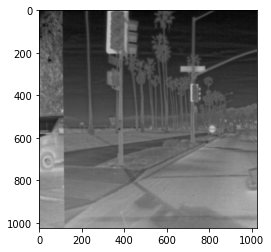

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


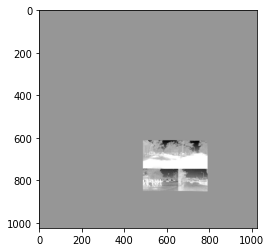

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


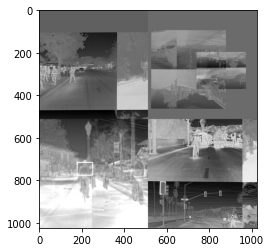

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


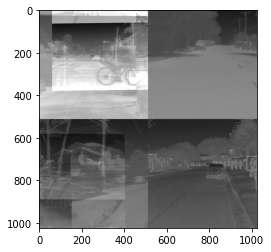

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


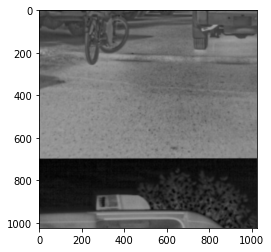

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


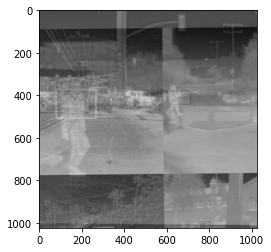

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


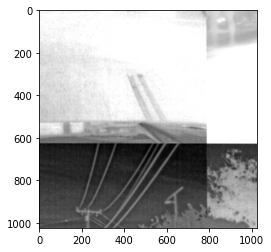

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


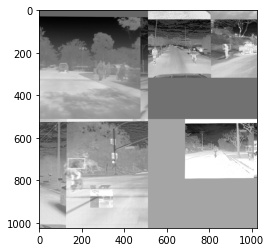

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


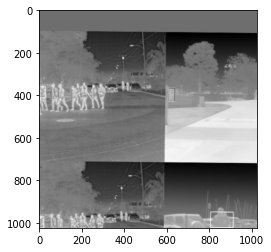

torch.Size([2, 3, 1024, 1024])
torch.Size([1024, 1024, 3])


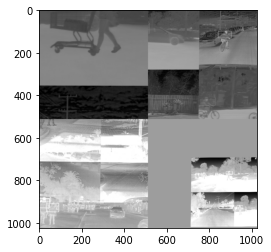

KeyboardInterrupt: 

In [72]:
import matplotlib as mpl
import torch
mpl.use('Agg')

pbar = enumerate(dataloader)

%matplotlib inline
from  matplotlib import pyplot as plt 
for i, (imgs, targets, paths, _) in pbar:
    print(imgs.shape)
    imgs = imgs.to(torch.float)
    
    img = (imgs[0]/255)
    img = torch.movedim(img, 0, -1)
    print(img.shape)
    plt.imshow(img)
    #arr = np.ndarray(img)#This is your tensor
    #arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
    #plt.imshow(arr_)
    plt.show()

In [41]:
(imgs[0]/255).reshape((1280,1280,3))

tensor([[[0.67059, 0.67451, 0.68235],
         [0.69020, 0.69412, 0.70196],
         [0.70980, 0.72941, 0.76471],
         ...,
         [0.10196, 0.15294, 0.16471],
         [0.12941, 0.11373, 0.11373],
         [0.12157, 0.13333, 0.14118]],

        [[0.70980, 0.71373, 0.72157],
         [0.71765, 0.70588, 0.70588],
         [0.72549, 0.73725, 0.74510],
         ...,
         [0.10980, 0.12549, 0.12941],
         [0.12157, 0.10196, 0.07843],
         [0.09412, 0.14510, 0.17255]],

        [[0.70980, 0.70980, 0.70196],
         [0.69020, 0.66667, 0.65882],
         [0.66667, 0.65490, 0.62745],
         ...,
         [0.09412, 0.10196, 0.10980],
         [0.11373, 0.12157, 0.12941],
         [0.13725, 0.15294, 0.16078]],

        ...,

        [[0.84314, 0.85098, 0.86275],
         [0.87059, 0.86667, 0.87059],
         [0.88235, 0.88235, 0.87843],
         ...,
         [1.00000, 1.00000, 1.00000],
         [1.00000, 1.00000, 1.00000],
         [1.00000, 1.00000, 1.00000]],

        [[

In [2]:
#centers as parameters
from torch.cuda import amp
import torch
import torch.optim as optim


count = 0
optimizer.zero_grad()
for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
    #print('!!!!!!!!!!!!!!!!!!!!!pbar:',pbar)
    #rint('!!!!!!!!!!!!!!!!!!!!!imgs:',imgs)
    #print('!!!!!!!!!!!!!!!!!!!!!targets:',targets)
    #print('!!!!!!!!!!!!!!!!!!!!!paths:',paths)
    #print('!!!!!!!!!!!!!!!!!!!!!_:',_)
    #import torchvision
    #images = torchvision.transforms.functional.to_tensor(imgs)
    
    imgs = imgs.to(torch.float)
    plt.imshow((imgs[0]/255).reshape((1280,1280,3)))
    print(imgs.shape)
    params_group = optimizer.param_groups
    centers = a[0]['params'][0]
    
    count+=1
    ind = idxs[count]
    s = 10
    sig = 5.07
    rotate_ran = 20
    im_np= imgs.numpy()
    #print(im_np)
    #im,im_r,im_b = model_patches(im_np,ind,centers,s,sig,rotate_ran)
    
    print('image shape:',imgs.shape)
    pred = model(imgs)  # forward
    ##print('pred:',pred)
    break
    loss, loss_items = compute_loss(pred, targets.to('cpu'))
    if opt.quad:
        loss *= 4.
    print('loss:',loss)
    print('obj_loss:',loss_items[1])
    scaler = amp.GradScaler()
    scaler.scale(loss).backward()
    #if ni % accumulate == 0:
    scaler.step(optimizer)  # optimizer.step
    scaler.update()
    optimizer.zero_grad()

C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.4sp5sua7cbgxueoc35yp2asoicyyeqzz.gfortran-win_amd64.dll
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


NameError: name 'optimizer' is not defined

In [4]:
cd yolov3

C:\Users\dell\huawei-working-folder\yolov3


In [5]:
# Train YOLOv3 on COCO128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov3.pt --nosave --cache

^C


In [8]:
import keras.losses
keras.losses.custom_loss = custom_loss

NameError: name 'custom_loss' is not defined

In [10]:
cd huawei-working-folder

C:\Users\dell\huawei-working-folder


In [13]:
!git https://github.com/Liu-Yicheng/YOLOv3.git

'git' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
#from torch import tensor
#imgp = np.expand_dims(img,axis = 0)
#imagep = tensor(imgp)
#pred = model(imagep)[0]

In [89]:
class opt():
    def __init__(self,source,weights):
        self.source = source
        self.weights = weights
        self.view_img = True
        self.img_size = 640
        self.conf_thres = 0.25
        self.iou_thres = 0.45
        self.max_det = 1000
        self.project = 'runs/detect'
        self.device = 'cpu'
        self.save_txt = 1
        self.nosave=0
        self.save_conf = 1
        self.name = 'exp'
        self.exist_ok=0
        self.augment = 0
        self.classes = 0
        self.hide_conf = False
        self.hide_labels = False
        self.line_thickness = 3
        self.update = 0
        self.agnostic_nms = 0
        self.save_crop = 0

In [90]:
from yolov3.detect import detect
import argparse

a = opt(source = 'FLIR_00320.jpeg',weights = 'yolov3.pt') 
box = detect(a)

YOLOv3  2021-9-8 torch 1.7.1+cu110 CPU

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients


image 1/1 C:\Users\dell\huawei-working-folder\FLIR_00320.jpeg: 512x640 1 person, Done. (1.146s)
Results saved to runs\detect\exp14
1 labels saved to runs\detect\exp14\labels
Done. (1.208s)


### PyTorch-YOLOv3

In [1]:
cd PyTorch-YOLOv3

C:\Users\dell\huawei-working-folder\PyTorch-YOLOv3


In [2]:
from pytorchyolo import detect, models
from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model

C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.4sp5sua7cbgxueoc35yp2asoicyyeqzz.gfortran-win_amd64.dll
C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [90]:
model = models.load_model(
  "config/yolov3.cfg", 
  "weights/yolov3.weights")

In [80]:
model

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [36]:
# Compute loss
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(model_fn(x), y)
# If attack is targeted, minimize loss of target label rather than maximize loss of correct label
if targeted:
    loss = -loss

# Define gradient of loss wrt input
loss.backward()
optimal_perturbation = optimize_linear(x.grad, eps, norm)

NameError: name 'outputs' is not defined

In [23]:
imgname = 'FLIR_00320.jpeg'
img = cv2.imread(imgname)

In [ ]:

with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        y = x * x### Gradient tape to get derivative of loss function
dy_dx = gg.gradient(y, x)     # Will compute to 6.0
d2y_dx2 = g.gradient(dy_dx, x) 

In [8]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import transforms
import cv2

#im = image.numpy()
im = cv2.imread("FLIR_08486.jpeg")
plt.imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")
predictor = DefaultPredictor(cfg) # create a defaultPredictor class to predictor
outputs = predictor(im)

1.9.0+cpu False


ModuleNotFoundError: No module named 'detectron2'

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

### 1. Gradient tape to get derivative of loss function
Problem: gradient is none, loss function not differentiable wrt imege input x?

In [10]:
#In our case,0 is no object, 1 is having object, p(have object) = 1-p(not have object)
import tensorflow as tf

y_true = [[0, 0], [0, 0]]
y_pred = [[0.68, 0.51], [0.78, 0.47]]
# Using default 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()


centers = tf.Variable([0.05,0.3,0.35,0.6,0.67,0.9])
y_true = tf.Variable([0])
#model.trainable_variables = centers
bce = tf.keras.losses.BinaryCrossentropy()
with tf.GradientTape(watch_accessed_variables=False) as tape:
    image = tf.Variable(image)
    tape.watch(image)
    #prediction = pretrained_model(image)
    prediction = tf.constant([0.7])
    loss = bce(y_true , prediction)
    # Get the gradients of the loss w.r.t to the input image.
gradient = tape.gradient(loss, centers)
# Get the sign of the gradients to create the perturbation
signed_grad = tf.sign(gradient)
print(signed_grad)



NameError: name 'image' is not defined

In [11]:
#Example 1
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for x, y in dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        tape.watch(x)
        # Forward pass.
        logits = model(x)
        # Loss value for this batch.
        loss_value = loss_fn(y, logits)

    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))


NameError: name 'dataset' is not defined

In [12]:
#Example 2
x = tf.constant(3.0)
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        y = x * x### Gradient tape to get derivative of loss function
dy_dx = gg.gradient(y, x)     # Will compute to 6.0
d2y_dx2 = g.gradient(dy_dx, x) 


### 2. Keras model and self define layer

In [13]:
model_input = list()
path = 'FLIR_people_select/train/images/'
pathlist = Path(path).rglob('*.jpeg')
for path in pathlist:
    path_in_str = str(path)
    print(path_in_str)
    image_raw = tf.io.read_file(path_in_str)
    image = tf.image.decode_image(image_raw,dtype=tf.dtypes.float32)
    image = tf.reshape(image,[1,327680])
    model_input.append(image)

FLIR_people_select\train\images\FLIR_00320.jpeg
FLIR_people_select\train\images\FLIR_00377.jpeg
FLIR_people_select\train\images\FLIR_00416.jpeg
FLIR_people_select\train\images\FLIR_00695.jpeg
FLIR_people_select\train\images\FLIR_00922.jpeg
FLIR_people_select\train\images\FLIR_00927.jpeg
FLIR_people_select\train\images\FLIR_00965.jpeg
FLIR_people_select\train\images\FLIR_01500.jpeg
FLIR_people_select\train\images\FLIR_01511.jpeg
FLIR_people_select\train\images\FLIR_01662.jpeg
FLIR_people_select\train\images\FLIR_01663.jpeg
FLIR_people_select\train\images\FLIR_01664.jpeg
FLIR_people_select\train\images\FLIR_01665.jpeg
FLIR_people_select\train\images\FLIR_01666.jpeg
FLIR_people_select\train\images\FLIR_01667.jpeg
FLIR_people_select\train\images\FLIR_01668.jpeg
FLIR_people_select\train\images\FLIR_01669.jpeg
FLIR_people_select\train\images\FLIR_01670.jpeg
FLIR_people_select\train\images\FLIR_01671.jpeg
FLIR_people_select\train\images\FLIR_01672.jpeg
FLIR_people_select\train\images\FLIR_016

FLIR_people_select\train\images\FLIR_02831.jpeg
FLIR_people_select\train\images\FLIR_02893.jpeg
FLIR_people_select\train\images\FLIR_02902.jpeg
FLIR_people_select\train\images\FLIR_02903.jpeg
FLIR_people_select\train\images\FLIR_02904.jpeg
FLIR_people_select\train\images\FLIR_02943.jpeg
FLIR_people_select\train\images\FLIR_02950.jpeg
FLIR_people_select\train\images\FLIR_02951.jpeg
FLIR_people_select\train\images\FLIR_02952.jpeg
FLIR_people_select\train\images\FLIR_02954.jpeg
FLIR_people_select\train\images\FLIR_02955.jpeg
FLIR_people_select\train\images\FLIR_02956.jpeg
FLIR_people_select\train\images\FLIR_02957.jpeg
FLIR_people_select\train\images\FLIR_02958.jpeg
FLIR_people_select\train\images\FLIR_02959.jpeg
FLIR_people_select\train\images\FLIR_02960.jpeg
FLIR_people_select\train\images\FLIR_02961.jpeg
FLIR_people_select\train\images\FLIR_02962.jpeg
FLIR_people_select\train\images\FLIR_03056.jpeg
FLIR_people_select\train\images\FLIR_03057.jpeg
FLIR_people_select\train\images\FLIR_031

FLIR_people_select\train\images\FLIR_04688.jpeg
FLIR_people_select\train\images\FLIR_04689.jpeg
FLIR_people_select\train\images\FLIR_04690.jpeg
FLIR_people_select\train\images\FLIR_04691.jpeg
FLIR_people_select\train\images\FLIR_04711.jpeg
FLIR_people_select\train\images\FLIR_04848.jpeg
FLIR_people_select\train\images\FLIR_04849.jpeg
FLIR_people_select\train\images\FLIR_04850.jpeg
FLIR_people_select\train\images\FLIR_04858.jpeg
FLIR_people_select\train\images\FLIR_04870.jpeg
FLIR_people_select\train\images\FLIR_04879.jpeg
FLIR_people_select\train\images\FLIR_04880.jpeg
FLIR_people_select\train\images\FLIR_04881.jpeg
FLIR_people_select\train\images\FLIR_04888.jpeg
FLIR_people_select\train\images\FLIR_04889.jpeg
FLIR_people_select\train\images\FLIR_04892.jpeg
FLIR_people_select\train\images\FLIR_04893.jpeg
FLIR_people_select\train\images\FLIR_04894.jpeg
FLIR_people_select\train\images\FLIR_04895.jpeg
FLIR_people_select\train\images\FLIR_04896.jpeg
FLIR_people_select\train\images\FLIR_048

FLIR_people_select\train\images\FLIR_07579.jpeg
FLIR_people_select\train\images\FLIR_07580.jpeg
FLIR_people_select\train\images\FLIR_07581.jpeg
FLIR_people_select\train\images\FLIR_07582.jpeg
FLIR_people_select\train\images\FLIR_07583.jpeg
FLIR_people_select\train\images\FLIR_07584.jpeg
FLIR_people_select\train\images\FLIR_07585.jpeg
FLIR_people_select\train\images\FLIR_07586.jpeg
FLIR_people_select\train\images\FLIR_07614.jpeg
FLIR_people_select\train\images\FLIR_07617.jpeg
FLIR_people_select\train\images\FLIR_07630.jpeg
FLIR_people_select\train\images\FLIR_07631.jpeg
FLIR_people_select\train\images\FLIR_07632.jpeg
FLIR_people_select\train\images\FLIR_07633.jpeg
FLIR_people_select\train\images\FLIR_07634.jpeg
FLIR_people_select\train\images\FLIR_07635.jpeg
FLIR_people_select\train\images\FLIR_07677.jpeg
FLIR_people_select\train\images\FLIR_07681.jpeg
FLIR_people_select\train\images\FLIR_07682.jpeg
FLIR_people_select\train\images\FLIR_07683.jpeg
FLIR_people_select\train\images\FLIR_076

In [14]:
import tensorflow as tf
from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()


input_shape = (512, 640, 1) #327680 #640 x 512

class MyDenseLayer(tf.keras.layers.Layer):
    #parameters
    global count
    def __init__(self, num_outputs):
        super(MyDenseLayer, self).__init__()
        self.num_outputs = num_outputs
    
    def build(self, input_shape):
        def initializer(*args, **kwargs):
            global count
            count = 0
            kernel =  tf.random.uniform((1,6),minval=0,maxval=1,dtype=tf.dtypes.float32)
            return kernel
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,6),
                                      initializer=initializer,
                                      trainable=True)
        super(MyDenseLayer, self).build(input_shape)

    def call(self, image_ori): #actual action of the layer
        def input_preprocess(image_ori):
            im_nd = image.numpy()
            #im_nd = np.repeat(im_nd, 3, axis=2)
            return im_nd
        
        global count
        ind = idxs[count]
        s = 10
        sig = 5.07
        rotate_ran = 20
        im,im_r,im_b = model_patches(image_ori,ind,self.kernel,s,sig,rotate_ran)
        im,im_r,im_b = input_preprocess(im),input_preprocess(im_r),input_preprocess(im_b)
        #get expected value for different transformation
        score = yolov3_score(image) # several people, take average
        score_r = yolov3_score(im_r)
        score_b = yolov3_score(im_b)
        score_expected = np.mean(score,score_r,score_b)
        
        #total_input, number of input images
        total_input = 710
        
        score = score_expected/total_input
        #score = rcnn()
        count+=1
        return score

layer = MyDenseLayer(6)
layer.build(input_shape) # <-- example of input shape
print(layer.trainable_variables)

class MyModel(tf.keras.Model):

    def __init__(self,layer):
        super(MyModel, self).__init__()
        self.layer = layer

    def call(self, inputs):
        #inputs are multiple/single image
        score = layer(inputs)
        return score # pred_result

model = MyModel(layer)
model.compile(loss= tf.keras.losses.MeanSquaredError(), optimizer='sgd')
#model.fit(inputs), image with label 0.

model.fit(model_input,tf.constant(0, shape = (1,710)),verbose=1)

[<tf.Variable 'kernel:0' shape=(1, 6) dtype=float32, numpy=
array([[0.9763032 , 0.49541724, 0.07656491, 0.72428405, 0.3039688 ,
        0.21315062]], dtype=float32)>]


ValueError: in user code:

    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    <ipython-input-14-15ac3e91f1f7>:66 call  *
        score = layer(inputs)
    <ipython-input-14-15ac3e91f1f7>:38 call  *
        im,im_r,im_b = model_patches(image_ori,ind,self.kernel,s,sig,rotate_ran)
    <ipython-input-5-b0726250a317>:83 model_patches  *
        patch = pat.multiple_gussians(centers,s,sig ,box_size, x ,y)
    C:\Users\dell\huawei-working-folder\patch.py:68 multiple_gussians  *
        yc = (1-centers[idx+1])*y
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\array_ops.py:1295 _SliceHelperVar
        return _slice_helper(var.value(), slice_spec, var)
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\array_ops.py:1041 _slice_helper
        return strided_slice(
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\array_ops.py:1214 strided_slice
        op = gen_array_ops.strided_slice(
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10537 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\dell\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 1 of dimension 0 out of bounds. for '{{node my_model/my_dense_layer/strided_slice_1}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](my_model/my_dense_layer/ReadVariableOp_1, my_model/my_dense_layer/strided_slice_1/stack, my_model/my_dense_layer/strided_slice_1/stack_1, my_model/my_dense_layer/strided_slice_1/stack_2)' with input shapes: [1,6], [1], [1], [1] and with computed input tensors: input[1] = <1>, input[2] = <2>, input[3] = <1>.


### 3. Keras backend

In [15]:
import keras.backend as K

# Get the loss and gradient of the loss wrt the inputs
loss = K.binary_crossentropy(1, 0)
grads = K.gradients(loss, model.input)

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
    return signed_grad

### cost implementation

import torch.nn.functional as F
input = tensor([[[[0.5546, 0.1304, 0.9288],
          [0.6879, 0.3553, 0.9984],
          [0.1474, 0.6745, 0.8948]],
         [[0.8524, 0.2278, 0.6476],
          [0.6203, 0.6977, 0.3352],
          [0.4946, 0.4613, 0.6882]]]])
target = tensor([[[1, 1, 1],
         [1, 1, 1],
         [0, 0, 1]]])

cost = F.cross_entropy(input,target)

input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)
loss.backward()

centers = [0.05,0.3,0.35,0.6,0.67,0.9]
#target = 0 #to minimize score, maximize loss

target = 

loss = K.categorical_crossentropy(, )
grads = K.gradients(loss,tensor(centers))


SyntaxError: invalid syntax (<ipython-input-15-24fb0227dbb2>, line 44)